In [ ]:
from imdb import IMDb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
import os
from pathlib import Path
from ipdb import set_trace
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time

pd.options.mode.chained_assignment = None

#### Data Acquisition and Setup

In [ ]:
ids_with_posters = os.listdir('Multi_Label_dataset/Images')
ids_with_posters = [i[:i.rindex('.')] for i in ids_with_posters]
imdb_data = pd.read_csv('imdb_data.csv')
data = imdb_data.query('id in @ids_with_posters & type == "movie"')
data.dropna(axis=0)
data.sort_values('releaseYear', inplace=True)
data

,id,title,type,genres,averageRating,numVotes,releaseYear
4821,tt0010949,The Adventurer,movie,"Adventure, Drama, History",2.4,25.0,1920.0
4822,tt0010950,The Adventures of Bob and Bill,movie,Adventure,5.2,24.0,1920.0
4825,tt0010953,Algol: Tragedy of Power,movie,"Fantasy, Sci-Fi",6.3,293.0,1920.0
4826,tt0010954,Alias Jimmy Valentine,movie,"Crime, Drama",6.7,20.0,1920.0
4827,tt0010955,Alias Miss Dodd,movie,"Comedy, Mystery",NaN,NaN,1920.0
...,...,...,...,...,...,...,...
806465,tt4034452,Hyena Road,movie,"Action, Drama, War",6.5,9313.0,2015.0
675570,tt2848292,Pitch Perfect 2,movie,"Comedy, Music",6.4,172926.0,2015.0
806935,tt4046784,Maze Runner: The Scorch Trials,movie,"Action, Adventure, Sci-Fi",6.3,285627.0,2015.0
594823,tt2265431,Me You and Five Bucks,movie,"Comedy, Drama, Romance",4.5,130.0,2016.0


In [ ]:
# A few movie posters don't have 3 color channels. Get rid of these to make the data set consistent.
# We only need to run this once after acquiring all our data.
run_this_cell = False
if run_this_cell:
    irregular_channels_ids = []
    for ind, movie_id in zip(data.index, data['id']):
        poster_path = Path(f'Multi_Label_dataset/Images/{movie_id}.jpg')
        poster = np.array(Image.open(poster_path))
        if poster.shape[-1] != 3:
            data.drop(ind, inplace=True)
            os.remove(poster_path)

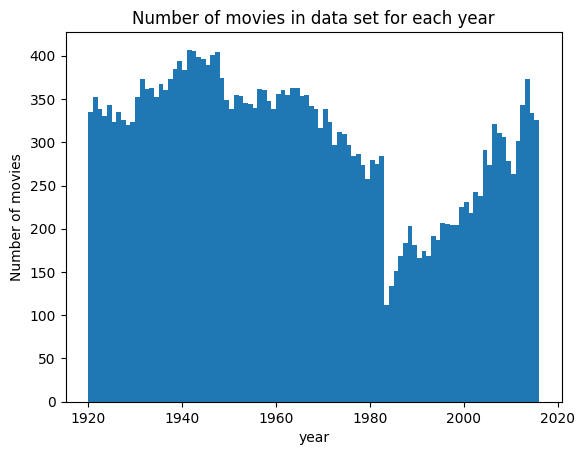

In [ ]:
plt.hist(data['releaseYear'], bins=len(data['releaseYear'].unique())-1)
plt.gca().set(xlabel='year', ylabel='Number of movies', title='Number of movies in data set for each year')
plt.show()

In [ ]:
run_this_cell = False # Only use this cell for dataset acquisition. Otherwise, turn it off so it doesn't accidentally get run.
if run_this_cell:
    ia = IMDb()
    for iter in range(212, 500):
        for year in np.arange(1920, 1983, dtype=float):
            data_year = imdb_data.query('releaseYear == @year')
            movie_id = data_year['id'].iloc[iter]
            try:
                movie = ia.get_movie(movie_id[2:])
                poster_url = movie.get('full-size cover url')
                response = requests.get(poster_url)
                img = Image.open(BytesIO(response.content))
                filename = f'Multi_Label_dataset/Images/{movie_id}.jpg'
                img.save(filename)
            except Exception:
                continue
        print(f'Completed iteration {iter}.')

In [ ]:
def sample_movies_by_year(df, start_year, end_year, n, year_column='releaseYear'):
    filtered_df = df[(df[year_column] >= start_year) & (df[year_column] <= end_year)]
    sampled_df = (filtered_df.groupby(year_column, group_keys=False).apply(lambda group: group.sample(n=n, random_state=42)))
    return sampled_df.reset_index(drop=True)

In [ ]:
data = data.query('releaseYear < 2016')

In [ ]:
n = np.min(data.groupby('releaseYear').size())
sampled_data = sample_movies_by_year(data, 1920, 2015, n=n)
sampled_data_test = sample_movies_by_year(data, 1920, 2015, 2)

C:\Users\Rickr\AppData\Local\Temp\ipykernel_72144\7521350.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = (filtered_df.groupby(year_column, group_keys=False).apply(lambda group: group.sample(n=n, random_state=42)))
C:\Users\Rickr\AppData\Local\Temp\ipykernel_72144\7521350.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = (filtered_df.groupby(year_column, group_keys=False).app

In [ ]:
sampled_data.shape

(10752, 7)

In [ ]:
def generate_id_pairs_by_year(df, id_column='id', year_column='releaseYear', downsample_freq=1001):
    year_to_ids = df.groupby(year_column)[id_column].apply(list).to_dict()
    year_combinations = list(combinations(year_to_ids.keys(), 2))
    pairs = []
    for year1, year2 in year_combinations:
        ids1 = year_to_ids[year1]
        ids2 = year_to_ids[year2]
        pairs.extend((int(id1[2:]), int(id2[2:])) for id1 in ids1 for id2 in ids2)
    pairs = np.array(pairs)
    np.random.shuffle(pairs)
    return pairs[::downsample_freq]

In [ ]:
id_pairs = generate_id_pairs_by_year(sampled_data, downsample_freq=5000)
labels = np.random.randint(0, 2, len(id_pairs))
id_pairs[labels==0] = id_pairs[labels==0][:, ::-1]

In [ ]:
id_pairs.shape

(5720, 2)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

poster_dict = {}
for movie_id in sampled_data['id']:
    poster = np.array(Image.open(f'Multi_Label_dataset/Images/{movie_id}.jpg'))
    poster_dict[int(movie_id[2:])] = transform(poster)
assert len(poster_dict) == sampled_data.shape[0]

In [ ]:
print(f'Downsampled pairs: {id_pairs.nbytes / (2**10):.2f}KB')
print(f'Labels: {labels.nbytes / (2**10):.2f}KB')

Downsampled pairs: 89.38KB
Labels: 22.34KB


#### Model Training

In [ ]:
class MoviePairDataset(Dataset):
    def __init__(self, pairs, labels, poster_dict):
        """
        Args:
            pairs (list of tuples): List of movie ID pairs.
            labels (list): List of binary labels (0 or 1).
            poster_dict (dict): Dictionary where keys are movie IDs and values are poster images.
        """
        self.pairs = pairs
        self.labels = labels
        self.poster_dict = poster_dict

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        id1, id2 = self.pairs[idx]
        label = self.labels[idx]

        poster1 = self.poster_dict[id1]
        poster2 = self.poster_dict[id2]

        return poster1, poster2, torch.tensor(label, dtype=torch.long)

In [ ]:
class PosterComparisonModel(nn.Module):
    def __init__(self, feature_dim=512):
        super(PosterComparisonModel, self).__init__()
        resnet = models.resnet18(pretrained=True) # Pretrained feature extractor (ResNet)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove the last layer
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(2 * feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, poster1, poster2):
        features1 = self.feature_extractor(poster1)
        features1 = self.flatten(features1)
        features2 = self.feature_extractor(poster2)
        features2 = self.flatten(features2)

        combined_features = torch.cat((features1, features2), dim=1)

        out = self.fc(combined_features)
        return out

In [ ]:
train_pairs, test_pairs, train_labels, test_labels = train_test_split(id_pairs, labels, test_size=0.2, random_state=42, shuffle=True)

train_dataset = MoviePairDataset(pairs=train_pairs, labels=train_labels, poster_dict=poster_dict)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MoviePairDataset(pairs=test_pairs, labels=test_labels, poster_dict=poster_dict)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(train_loader))
print(len(test_loader))

143
36


In [ ]:
# Training loop
def train_model(model, train_loader, optimizer, criterion, device, epoch_num, print_freq=100):
    model.train()
    model.to(device)
    total_loss = 0
    last_printout_time = time.time()
    loss_list, acc_list = [], []
    overall_loss_list, overall_acc_list = [], []
    for i, (poster1, poster2, labels) in enumerate(train_loader):
        poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

        # Forward pass
        outputs = model(poster1, poster2)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get loss and accuracy metrics
        loss_item = loss.item()
        total_loss += loss_item
        loss_list.append(loss_item)
        overall_loss_list.append(loss_item)

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total
        acc_list.append(accuracy)
        overall_acc_list.append(accuracy)

        # Occasionally print results
        if print_freq > 0 and i % print_freq == 0 and i != 0:
            print(f'Epoch {epoch_num} Batch {i}: Loss: {loss.item():.2g}, Accuracy: {accuracy*100:.2f}%')
            print(f'Avg loss since last printout: {np.mean(loss_list):.2g}, Accuracy since last printout: {np.mean(acc_list)*100:.2f}%')
            print(f'Those {print_freq} batches took {time.time() - last_printout_time:.2f}s.')
            loss_list, acc_list = [], []
            last_printout_time = time.time()
            print('-'*100)

    return overall_loss_list, overall_acc_list

# Testing loop
def test_model(model, test_loader, device):
    model.eval()
    model.to(device)
    accs = []

    with torch.no_grad():
        for poster1, poster2, labels in test_loader:
            poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

            # Forward pass
            outputs = model(poster1, poster2)
            _, predicted = torch.max(outputs, 1)

            accs.append((predicted == labels).sum() / labels.size(0))

    return accs

In [ ]:
# Initialize model, loss, and optimizer
model = PosterComparisonModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10

test_accs = []
train_batch_accs = []
train_batch_losses = []
test_batch_accs = []
initial_test_accs = test_model(model, test_loader, device)
print(f'Baseline: Test Accuracy: {np.mean(initial_test_accs)*100:.1f}% (Should be around 50%)')
print('-'*100)
print('-'*100)
for epoch in range(num_epochs):
    train_losses, train_accs = train_model(model, train_loader, optimizer, criterion, device, epoch+1, print_freq=20)
    test_accs = test_model(model, test_loader, device)
    train_batch_accs.extend(train_accs)
    train_batch_losses.extend(train_losses)
    test_batch_accs.extend(test_accs)

    print('-'*100)
    print(f"Epoch {epoch + 1}, Loss: {np.mean(train_losses):.4f}, Test Accuracy: {np.mean(test_accs)*100:.2f}%")
    print('-'*100)
    print('-'*100)

Baseline: Test Accuracy: 51.8% (Should be around 50%)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Batch 20: Loss: 0.65, Accuracy: 65.62%
Avg loss since last printout: 0.69, Accuracy since last printout: 55.21%
Those 20 batches took 115.80s.
----------------------------------------------------------------------------------------------------
Batch 40: Loss: 0.69, Accuracy: 50.00%
Avg loss since last printout: 0.67, Accuracy since last printout: 59.84%
Those 20 batches took 113.17s.
----------------------------------------------------------------------------------------------------
Batch 60: Loss: 0.64, Accuracy: 59.38%
Avg loss since last printout: 0.66, Accuracy since last printout: 63.91%
Those 20 batches took 111.71s.
----------------------------------------------------------------------------------------------------
Batch 80: Lo

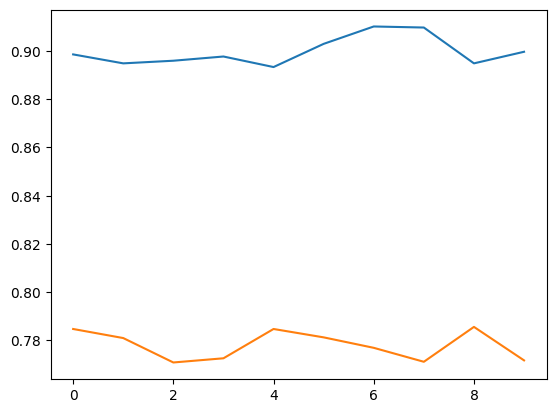

In [ ]:
train_batch_accs = np.array(train_batch_accs)
train_batch_losses = np.array(train_batch_losses)
test_batch_accs = np.array(test_batch_accs)
train_epoch_accs = np.mean(train_batch_accs.reshape((len(train_loader), -1)), axis=0)
train_epoch_losses = np.mean(train_batch_losses.reshape((len(train_loader), -1)), axis=0)
test_epoch_accs = np.mean(test_batch_accs.reshape((len(test_loader), -1)), axis=0)
plt.plot(train_epoch_accs)
plt.plot(test_epoch_accs)

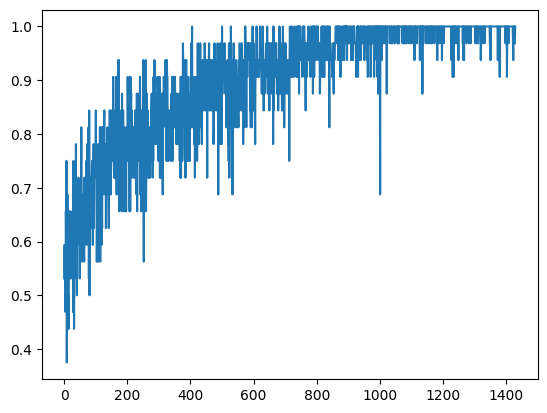

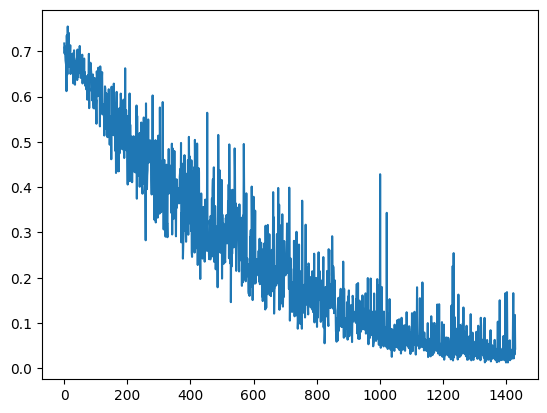

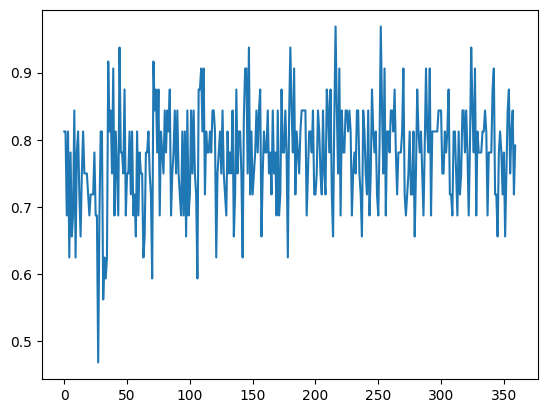

In [ ]:
plt.plot(train_batch_accs)
plt.show()
plt.plot(train_batch_losses)
plt.show()
plt.plot(test_batch_accs)
plt.show()

#### Test model by constructing confusion matrix

In [ ]:
num_per_year = 10
super_subsampled_data = sampled_data.groupby('releaseYear').head(num_per_year)
# super_subsampled_data = super_subsampled_data.query('releaseYear > 1950')

In [ ]:
cm_id_pairs = []
cm_years = []
for year1 in super_subsampled_data['releaseYear'].unique():
    for year2 in super_subsampled_data['releaseYear'].unique():
        if year1 == year2:
            continue
        year1_ids = super_subsampled_data.query('releaseYear==@year1')['id'].values
        year2_ids = super_subsampled_data.query('releaseYear==@year2')['id'].values
        year1_ids = np.array([int(id[2:]) for id in year1_ids])
        year2_ids = np.array([int(id[2:]) for id in year2_ids])
        
        both_years_ids = np.vstack((year1_ids, year2_ids)).T
        cm_id_pairs.append(both_years_ids)
        cm_years.append(np.array([[year1, year2]]*num_per_year))
cm_id_pairs = np.vstack(cm_id_pairs)
cm_years = np.vstack(cm_years)

cm_dataset = MoviePairDataset(pairs=cm_id_pairs, labels=cm_years, poster_dict=poster_dict)
cm_loader = DataLoader(cm_dataset, batch_size=128, shuffle=False)
print(f'{len(cm_loader)} batches, {cm_id_pairs.shape[0]} pairs')

713 batches, 91200 pairs


In [ ]:
num_years = int(len(super_subsampled_data['releaseYear'].unique()))
confusion_matrix = np.zeros((num_years, num_years)).astype('int32')
confusion_matrix[np.identity(num_years).astype(bool)] = -1
first_year = int(super_subsampled_data['releaseYear'].min())
printout_freq = 50
print_start_time = time.time()

with torch.no_grad():
    for batch_num, (poster1, poster2, years) in enumerate(cm_loader):
        batch_start_time = time.time()
        poster1, poster2, years = poster1.to(device), poster2.to(device), (years-first_year).to(device)
        labels = (years[:,0] < years[:,1]).to(torch.int32)

        # Forward pass
        outputs = model(poster1, poster2)
        _, predicted = torch.max(outputs, 1)

        correct = predicted == labels
        np.add.at(confusion_matrix, tuple(years[correct].T), 1)

        if batch_num != 0 and batch_num % printout_freq == 0:
            time_now = time.time()
            print(f'Completed {batch_num+1}/{len(cm_loader)} batches.')
            print(f'Time taken: Last batch {time_now - batch_start_time:.2f}s, last {printout_freq} batches {time_now - print_start_time:.2f}s.')
            print_start_time = time.time()

Completed 51/713 batches.
Time taken: Last batch 9.07s, last 50 batches 417.49s.
Completed 101/713 batches.
Time taken: Last batch 9.17s, last 50 batches 507.26s.
Completed 151/713 batches.
Time taken: Last batch 9.08s, last 50 batches 437.91s.
Completed 201/713 batches.
Time taken: Last batch 9.19s, last 50 batches 475.87s.
Completed 251/713 batches.
Time taken: Last batch 7.53s, last 50 batches 438.19s.
Completed 301/713 batches.
Time taken: Last batch 7.44s, last 50 batches 391.06s.
Completed 351/713 batches.
Time taken: Last batch 7.59s, last 50 batches 382.12s.
Completed 401/713 batches.
Time taken: Last batch 7.30s, last 50 batches 396.12s.
Completed 451/713 batches.
Time taken: Last batch 7.36s, last 50 batches 380.91s.


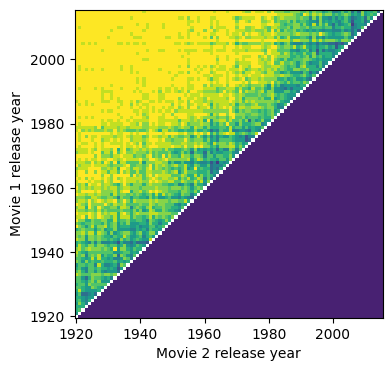

In [ ]:
for row_num in range(confusion_matrix.shape[0]):
    for col_num in range(confusion_matrix.shape[1]):
        confusion_matrix[col_num, row_num] = confusion_matrix[row_num, col_num]

fig = plt.figure(figsize=(4,4))
cmap = plt.cm.viridis
norm = plt.Normalize(confusion_matrix.min(), confusion_matrix.max())
rgba = cmap(norm(confusion_matrix))
rgba[range(len(confusion_matrix)), range(len(confusion_matrix)), :3] = 1, 1, 1
plt.imshow(rgba)
plt.gca().invert_yaxis()
range_number, coef, offset = 5, 20, int(super_subsampled_data['releaseYear'].min())
plt.xticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])
plt.yticks([coef*i for i in range(range_number)], [coef*i+offset for i in range(range_number)])
# plt.xticks([20*i for i in range(5)], [1920+20*i for i in range(5)])
# plt.yticks([20*i for i in range(5)], [1920+20*i for i in range(5)])
# plt.colorbar()
plt.gca().set(ylabel='Movie 1 release year', xlabel='Movie 2 release year')
plt.show()

In [ ]:
def sum_near_diagonal(matrix, n):
    rows, cols = matrix.shape
    total_sum = 0
    for i in range(rows):
        for j in range(cols):
            if abs(i - j) <= n:
                total_sum += matrix[i, j]
    return total_sum

In [ ]:
incorrects = (10 - confusion_matrix - 10*np.identity(len(confusion_matrix))).astype(int)
print(f'Total number of incorrect guesses: {np.sum(incorrects)}')
n = 25
close_incorrects = sum_near_diagonal(incorrects, n)
print(f'Number of incorrects within {n} years of one another: {close_incorrects} ({close_incorrects / np.sum(incorrects) * 100:.2f}%)')

Total number of incorrect guesses: 53550
Number of incorrects within 25 years of one another: 27335 (51.05%)
